In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

print("Torch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Dataset central (avec patchs + csv)
DATA_ROOT = "/kaggle/input/"
CSV_PATH  = os.path.join(DATA_ROOT, "split-wsi-level/patches_metadata_with_split.csv")
PATCH_DIR = os.path.join(DATA_ROOT, "camelyon-prepro-v4-patches/patches")

df = pd.read_csv(CSV_PATH)
print("Rows:", len(df), " | WSI:", df["wsi_id"].nunique())
print(df["split"].value_counts())
df.head()


Torch: 2.6.0+cu124
Device: cpu
Rows: 16800  | WSI: 56
split
train    11700
test      2700
val       2400
Name: count, dtype: int64


,patch_path,wsi_id,x,y,label,split
0,/kaggle/working/patches/normal_074_x54016_y698...,normal_074,54016,69888,0,train
1,/kaggle/working/patches/normal_074_x18688_y744...,normal_074,18688,74496,0,train
2,/kaggle/working/patches/normal_074_x48640_y757...,normal_074,48640,75776,0,train
3,/kaggle/working/patches/normal_074_x50688_y757...,normal_074,50688,75776,0,train
4,/kaggle/working/patches/normal_074_x50944_y757...,normal_074,50944,75776,0,train


In [2]:
df["patch_file"] = df["patch_path"].apply(os.path.basename)
df["img_path"] = df["patch_file"].apply(lambda f: os.path.join(PATCH_DIR, f))

# Check fichiers trouvés
exists_ratio = df["img_path"].apply(os.path.exists).mean()
print(f"Images found: {exists_ratio*100:.2f}%")
assert exists_ratio > 0.99, "Paths incorrects: beaucoup d'images manquent."


Images found: 100.00%


In [3]:
OUT_DIR = "/kaggle/working/embeddings_vit"
os.makedirs(OUT_DIR, exist_ok=True)

FEATS_PATH = os.path.join(OUT_DIR, "features.npy")
DONE_PATH  = os.path.join(OUT_DIR, "done.npy")
INDEX_PATH = os.path.join(OUT_DIR, "index.csv")
META_PATH  = os.path.join(OUT_DIR, "run_config.txt")

print("OUT_DIR:", OUT_DIR)


OUT_DIR: /kaggle/working/embeddings_vit


In [4]:
IMG_SIZE = 224

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

class PatchDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["img_path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        meta = {
            "idx": idx,
            "wsi_id": row["wsi_id"],
            "x": int(row["x"]),
            "y": int(row["y"]),
            "label": int(row["label"]),
            "split": row["split"],
            "patch_file": row["patch_file"],
        }
        return img, meta

dataset = PatchDataset(df, transform=transform)
print("Dataset:", len(dataset))


Dataset: 16800


In [5]:
def collate_fn(batch):
    imgs = torch.stack([b[0] for b in batch], dim=0)
    metas = {k: [b[1][k] for b in batch] for k in batch[0][1].keys()}
    return imgs, metas

BATCH_SIZE = 64

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    collate_fn=collate_fn
)

len(loader)


263

In [6]:
!pip install timm -q
import timm
import torch.nn as nn

MODEL_NAME = "vit_base_patch16_224"

model = timm.create_model(MODEL_NAME, pretrained=True)
if hasattr(model, "head"):
    model.head = nn.Identity()

model = model.to(device).eval()

with torch.no_grad():
    dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
    out = model(dummy)
    EMBED_DIM = out.shape[-1]

print("Model:", MODEL_NAME, "| EMBED_DIM:", EMBED_DIM)

# log config
with open(META_PATH, "w") as f:
    f.write(f"MODEL_NAME={MODEL_NAME}\nIMG_SIZE={IMG_SIZE}\nBATCH_SIZE={BATCH_SIZE}\nEMBED_DIM={EMBED_DIM}\n")
print("Config saved:", META_PATH)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 23.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requi

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Model: vit_base_patch16_224 | EMBED_DIM: 768
Config saved: /kaggle/working/embeddings_vit/run_config.txt


In [7]:
N = len(dataset)

# index.csv (une fois)
if not os.path.exists(INDEX_PATH):
    index_df = df[["wsi_id","x","y","label","split","patch_file"]].copy()
    index_df.to_csv(INDEX_PATH, index=False)
    print("Index saved:", INDEX_PATH)
else:
    print("Index exists:", INDEX_PATH)

# done.npy
if os.path.exists(DONE_PATH):
    done = np.load(DONE_PATH)
    assert done.shape[0] == N
    print("Checkpoint found: done =", done.sum(), "/", N)
else:
    done = np.zeros((N,), dtype=np.bool_)
    np.save(DONE_PATH, done)
    print("No checkpoint: initialized done.npy")

# features.npy (memmap float16 pour réduire taille)
if not os.path.exists(FEATS_PATH):
    feats_mm = np.memmap(FEATS_PATH, dtype=np.float16, mode="w+", shape=(N, EMBED_DIM))
    feats_mm.flush()
    print("Created features memmap:", FEATS_PATH)
else:
    feats_mm = np.memmap(FEATS_PATH, dtype=np.float16, mode="r+", shape=(N, EMBED_DIM))
    print("Loaded features memmap:", FEATS_PATH)


Index saved: /kaggle/working/embeddings_vit/index.csv
No checkpoint: initialized done.npy
Created features memmap: /kaggle/working/embeddings_vit/features.npy


In [8]:
SAVE_EVERY = 50  # checkpoint toutes les 50 itérations DataLoader (~50 batches)

processed_now = 0

with torch.no_grad():
    pbar = tqdm(enumerate(loader), total=len(loader), desc="Extract")
    for step, (imgs, metas) in pbar:
        idxs = np.array(metas["idx"], dtype=np.int64)

        # skip si tout le batch est déjà fait
        if done[idxs].all():
            continue

        imgs = imgs.to(device, non_blocking=True)
        out = model(imgs)                 # [B, D]
        out = out.detach().cpu().numpy().astype(np.float16)

        # écrire seulement les idx non faits
        for i, idx in enumerate(idxs):
            if not done[idx]:
                feats_mm[idx, :] = out[i]
                done[idx] = True
                processed_now += 1

        if step % SAVE_EVERY == 0:
            np.save(DONE_PATH, done)
            feats_mm.flush()
            pbar.set_postfix(done=int(done.sum()), new=processed_now)

# final save
np.save(DONE_PATH, done)
feats_mm.flush()

print("DONE:", int(done.sum()), "/", N, "| newly processed:", processed_now)
print("Embeddings:", FEATS_PATH)
print("Done mask :", DONE_PATH)
print("Index     :", INDEX_PATH)


Extract: 100%|██████████| 263/263 [1:35:03<00:00, 21.69s/it, done=16064, new=16064]

DONE: 16800 / 16800 | newly processed: 16800
Embeddings: /kaggle/working/embeddings_vit/features.npy
Done mask : /kaggle/working/embeddings_vit/done.npy
Index     : /kaggle/working/embeddings_vit/index.csv


In [9]:
# quick checks
done = np.load(DONE_PATH)
print("Done ratio:", done.mean())

# lire 3 embeddings au hasard
rand_idx = np.random.choice(np.where(done)[0], size=3, replace=False)
print("Sample idx:", rand_idx)
print(np.array(feats_mm[rand_idx, :], dtype=np.float32)[:, :5])  # 5 premières dims


Done ratio: 1.0
Sample idx: [3212 8140 3864]
[[ 0.16662598 -0.05419922 -1.0097656  -0.36669922 -0.11932373]
 [ 3.4003906  -1.7294922  -2.5097656  -0.4074707  -0.79833984]
 [-0.72021484 -0.02890015 -1.2138672   0.06176758  0.58251953]]


In [10]:
import numpy as np
import pandas as pd

# recharger memmap proprement (au cas où)
N = len(df)
feats = np.memmap(FEATS_PATH, dtype=np.float16, mode="r", shape=(N, EMBED_DIM))
done = np.load(DONE_PATH)

print("DONE:", done.sum(), "/", N)

# Convert petit sample en float32 pour checks robustes
idx = np.random.choice(np.where(done)[0], size=2000, replace=False)
X = np.array(feats[idx], dtype=np.float32)

print("NaN count:", np.isnan(X).sum())
print("Inf count:", np.isinf(X).sum())

# Normes L2 (magnitude) -> si tout est ~0 ou constant, y'a un souci
norms = np.linalg.norm(X, axis=1)
print("Norms: min/mean/max =", norms.min(), norms.mean(), norms.max())
print("Norms std =", norms.std())

# Vérifier si beaucoup d'embeddings sont identiques (approx)
# (sur un sample, on regarde combien de lignes uniques)
X_round = np.round(X, 3)  # tolérance
unique_ratio = np.unique(X_round, axis=0).shape[0] / X_round.shape[0]
print("Approx unique ratio (rounded 1e-3):", unique_ratio)


DONE: 16800 / 16800
NaN count: 0
Inf count: 0
Norms: min/mean/max = 25.966799 39.59171 69.84885
Norms std = 6.6868024
Approx unique ratio (rounded 1e-3): 1.0


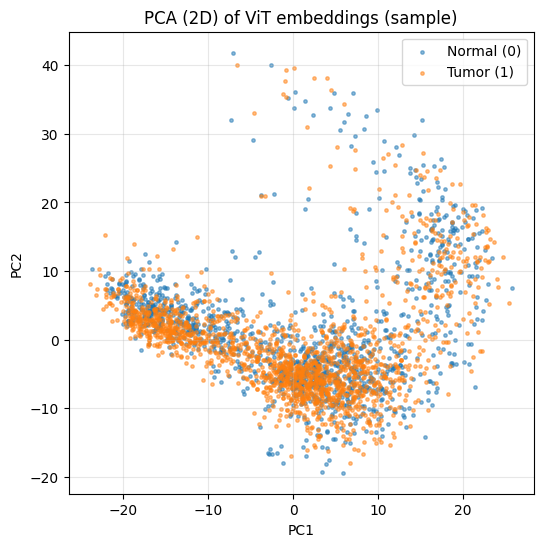

Explained variance ratio: [0.16910161 0.09304032]


In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Sample pour aller vite
sample_n = 3000
idx = np.random.choice(np.where(done)[0], size=sample_n, replace=False)

X = np.array(feats[idx], dtype=np.float32)
y = df.loc[idx, "label"].values

pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X)

plt.figure(figsize=(6,6))
plt.scatter(Z[y==0,0], Z[y==0,1], s=6, alpha=0.5, label="Normal (0)")
plt.scatter(Z[y==1,0], Z[y==1,1], s=6, alpha=0.5, label="Tumor (1)")
plt.title("PCA (2D) of ViT embeddings (sample)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)


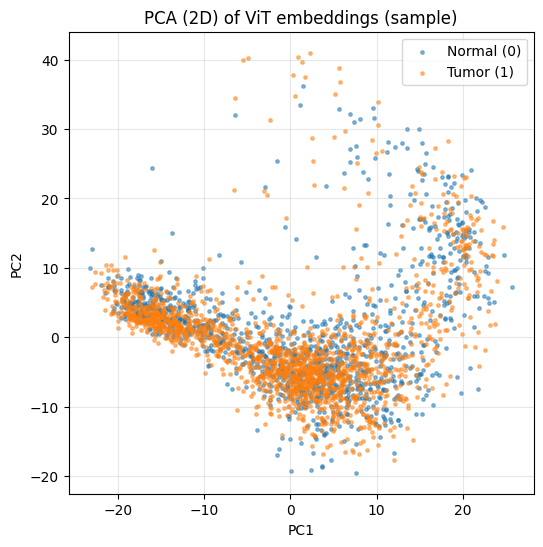

Explained variance ratio: [0.16961832 0.09144241]


In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Sample pour aller vite
sample_n = 3000
idx = np.random.choice(np.where(done)[0], size=sample_n, replace=False)

X = np.array(feats[idx], dtype=np.float32)
y = df.loc[idx, "label"].values

pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X)

plt.figure(figsize=(6,6))
plt.scatter(Z[y==0,0], Z[y==0,1], s=6, alpha=0.5, label="Normal (0)")
plt.scatter(Z[y==1,0], Z[y==1,1], s=6, alpha=0.5, label="Tumor (1)")
plt.title("PCA (2D) of ViT embeddings (sample)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)


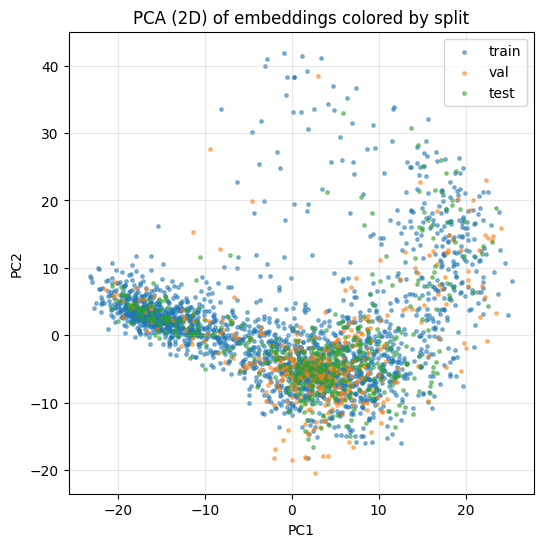

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

sample_n = 3000
idx = np.random.choice(np.where(done)[0], size=sample_n, replace=False)

X = np.array(feats[idx], dtype=np.float32)
spl = df.loc[idx, "split"].values

pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X)

plt.figure(figsize=(6,6))
for name in ["train", "val", "test"]:
    m = (spl == name)
    plt.scatter(Z[m,0], Z[m,1], s=6, alpha=0.5, label=name)

plt.title("PCA (2D) of embeddings colored by split")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


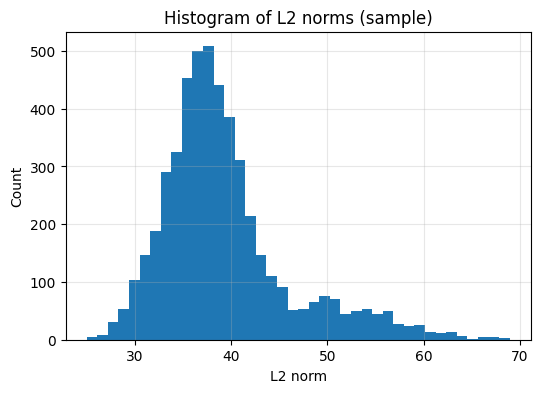

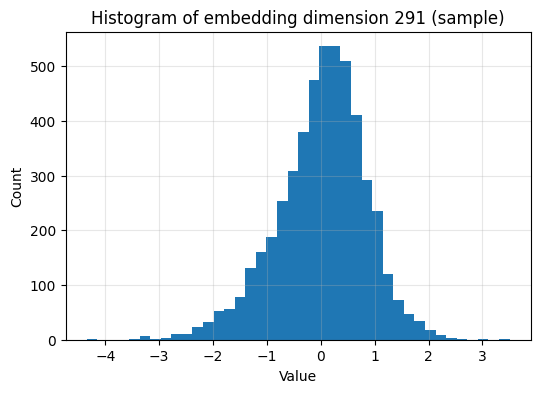

In [14]:
import matplotlib.pyplot as plt
import numpy as np

idx = np.random.choice(np.where(done)[0], size=5000, replace=False)
X = np.array(feats[idx], dtype=np.float32)

norms = np.linalg.norm(X, axis=1)

plt.figure(figsize=(6,4))
plt.hist(norms, bins=40)
plt.title("Histogram of L2 norms (sample)")
plt.xlabel("L2 norm")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()

d = np.random.randint(0, EMBED_DIM)
plt.figure(figsize=(6,4))
plt.hist(X[:, d], bins=40)
plt.title(f"Histogram of embedding dimension {d} (sample)")
plt.xlabel("Value")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()
